In [7]:
import numpy as np
from numpy.random import rand
import random
import matplotlib.pyplot as plt
from numba import int32, int64, float32
from numba.types import List
from numba import jitclass, jit, njit, prange

In [24]:
spec = [
    ('N', int32),
    ('T', float32),
    ('J', float32),
    ('h', float32),
    ('time', int32),   
    ('config', List(List(int64))),
]

@jitclass(spec)
class Ising():
  ''' Simulating the 2D Ising model '''
  def __init__(self, N, temp, J , h , config):
    self.N = N
    self.T = temp
    self.J = J
    self.h = h
    self.time = 0
    self.config = config

  def energy(self):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(self.config)):
      for j in range(len(self.config)):
        S = self.config[i][j]
        nb = self.config[(i+1)%self.N][j] + self.config[i][(j+1)%self.N] + self.config[(i-1)%self.N][j] + self.config[i][(j-1)%self.N]
        energy += self.J*nb*S + self.h*S
    return energy/4

  def magnetization(self):
    '''Magnetization of a given configuration'''
    mag = 0
    for i in range(len(self.config)):
      for j in range(len(self.config)):
        mag += self.config[i][j]
    return mag

  
  ## monte carlo moves
  def mcmove(self):
    ''' This is to execute the monte carlo moves using 
    Metropolis algorithm such that detailed
    balance condition is satisified'''
    beta = 1.0/self.T
    for i in range(self.N):
      for j in range(self.N):            
        a = np.random.randint(0, self.N)
        b = np.random.randint(0, self.N)
        s =  self.config[a][b]
        nb = self.config[(a+1)%self.N][b] + self.config[a][(b+1)%self.N] + self.config[(a-1)%self.N][b] + self.config[a][(b-1)%self.N]
        cost = -2*self.J*s*nb - 2*self.h*s 
        if cost < 0 or rand() < np.exp(-cost*beta):
          s *= -1
        self.config[a][b] = s

  def evolve(self, n_iter, h_values=None):   
    ''' This module simulates the evolution of Ising model'''
    magnetizations = np.zeros(n_iter)
    for i in range(n_iter):
      if h_values is not None:
        self.h = h_values[i]
      self.mcmove()
      magnetizations[i] = self.magnetization()
      self.time += 1
    return magnetizations

  def thermalize(self):
    for i in range(500): 
      self.mcmove()

  def reset_protocol(self, n_iter=1000, hmax=2):
    ''' This module simulates the reset-to-one protocol'''
    starting_h = self.h
    #Initial state is thermalized   
    self.thermalize()

    #First control ramp
    upward_ramp = np.linspace(starting_h, hmax, n_iter)
    upward_m = self.evolve(n_iter, upward_ramp)
    

    #Second control ramp
    downward_ramp = np.linspace(hmax, starting_h, n_iter)
    downward_m = self.evolve(n_iter, downward_ramp)

    h_ramp = np.concatenate((upward_ramp, downward_ramp))
    mag_values = np.concatenate((upward_m, downward_m))
    
    return mag_values, h_ramp

In [25]:
@jit(nopython=True, fastmath=True)
def workIntegral(mag_values, h_ramp):
  steps = h_ramp.shape[0]-1
  work = 0
  for i in range(steps):
    work += (h_ramp[i+1]-h_ramp[i])*(mag_values[i+1]+ mag_values[i])/2
  
  return work

def configPlot(ising_obj):

  ''' This modules plots the configuration of the Ising model'''
  X, Y = np.meshgrid(range(ising_obj.N), range(ising_obj.N))
  e = ising_obj.energy()/(ising_obj.N**2)
  m = ising_obj.magnetization()/(ising_obj.N**2)
  f = plt.figure(figsize=(5,5), dpi=80)
  sp =  f.add_subplot(1, 1, 1)  
  plt.setp(sp.get_yticklabels(), visible=False)
  plt.setp(sp.get_xticklabels(), visible=False)      
  plt.pcolormesh(X, Y, ising_obj.config, vmin=-1, vmax=1, cmap=plt.cm.RdBu)
  plt.title('t={0}, E={1}, M={2}'.format(ising_obj.time,round(e,5),round(m,5))) 
  plt.axis('tight')    
  plt.show()

In [29]:
@njit(parallel=True, nogil=True)
def sampleRun(N, h_max, n_steps, T, num_samples):
  W = []
  mag_configs = []
  M = 0
  for i in prange(num_samples):
    initial_config = [[2*random.randint(0,1)-1 for i in range(N)] for j in range(N)]
    rm = Ising(N, T, -1, 0, initial_config)
    mag_values, h_ramp = rm.reset_protocol(n_steps,h_max)
    mag_configs.append(mag_values)
    W.append(workIntegral(mag_values, h_ramp))
    M += rm.magnetization()
  
  return W, mag_configs, M

In [30]:
# Parameters
N = 64
num_samples = 1000
h_max = .5
n_steps = 200
T = 1.5


Average Work / Tlog(2):  1283.3408431144119
Average Normalized Magnetization:  -0.98657568359375
Jarzynski (global average):  0.101053487951121


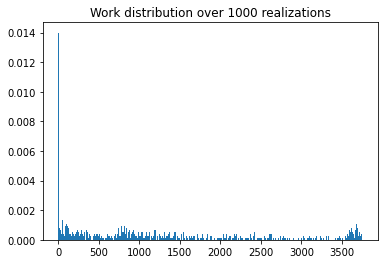

CPU times: user 26min 36s, sys: 689 ms, total: 26min 36s
Wall time: 13min 34s


In [31]:
%%time
W, _, M = sampleRun(N, h_max, n_steps, T, num_samples)

print('')
print('Average Work / Tlog(2): ', np.mean(W)/(T*np.log(2)))
print('Average Normalized Magnetization: ', M/(num_samples*N*N))
print('Jarzynski (global average): ', np.mean(np.exp(-np.array(W)/T)))

plt.hist(W, density=True, bins=500) # best automatic binning bins='doane'
plt.title('Work distribution over {0} realizations'.format(num_samples))
plt.show()